In [1]:
!pip install tf-nightly-2.0-preview


     |████████████████████████████████| 95.2MB 110kB/s 
     |████████████████████████████████| 3.8MB 39.6MB/s 
     |████████████████████████████████| 450kB 47.4MB/s 
     |████████████████████████████████| 81kB 9.6MB/s 
ERROR: google-colab 1.0.0 has requirement google-auth~=1.4.0, but you'll have google-auth 1.6.3 which is incompatible.
ERROR: tb-nightly 2.1.0a20191027 has requirement grpcio>=1.24.3, but you'll have grpcio 1.15.0 which is incompatible.
  Found existing installation: google-auth 1.4.2
    Uninstalling google-auth-1.4.2:
      Successfully uninstalled google-auth-1.4.2


In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
print(tf.__version__)

2.0.0-dev20191002


# Generating data

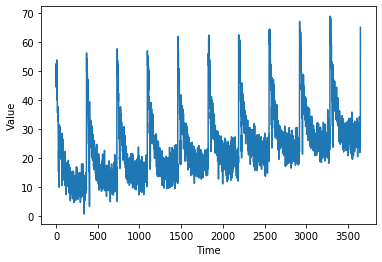

In [29]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(False)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.1,
                    np.cos(season_time * 5 * np.pi),
                    1 / np.exp(6 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

time = np.arange(10 * 365 + 1, dtype="float32")
series = trend(time, 0.1)  
baseline = 9
amplitude = 40
slope = 0.005
noise_level = 3

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=51)

split_time = 3000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

plot_series(time, series)

# Creating and training model

In [0]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

In [0]:
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)


model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(20, input_shape=[window_size], activation='relu'),
    tf.keras.layers.Dense(15 , activation="relu"), 
    tf.keras.layers.Dense(1)
])

#Choosing good learning rate
# lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-8 * 10**(epoch / 20))
# optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
# model.compile(loss="mse", optimizer=optimizer)
# history = model.fit(dataset, epochs=100, callbacks=[lr_schedule], verbose=0)
# lrs = 1e-8 * (10 ** (np.arange(100) / 20))
# plt.semilogx(lrs, history.history["loss"])
# plt.axis([1e-8, 1e-3, 0, 300])

model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(lr=1e-6, momentum=0.9))
history = model.fit(dataset,epochs=500,verbose=0)

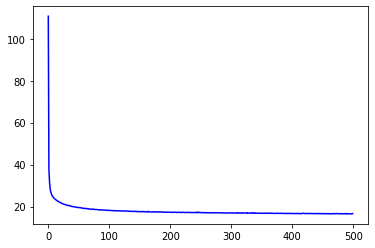

In [42]:
#Plot loss function
loss = history.history['loss']
epochs = range(len(loss))
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.show()

[23.76687308189853, 23.521573073111924, 23.30361057511912, 23.052127807412372, 22.83744125878251, 22.723145927518807, 22.376698294261956, 22.317718555783266, 22.15071906787437, 21.958776962517092, 21.784478101314313, 21.664015474255454, 21.4335646482122, 21.363684004585213, 21.265611617837177, 21.15468027831724, 21.04182238482789, 20.95675708079498, 20.804890162832784, 20.782302572263166, 20.63977559236872, 20.618820706309887, 20.46623596601038, 20.451382974650237, 20.472832637505242, 20.495541566170303, 20.27537155919427, 20.142376043332504, 20.13696091927138, 20.005426592474816, 19.941848109712538, 19.88591645387995, 19.856459305270405, 19.813732366113854, 19.78843594429477, 19.74586596392945, 19.599990620069057, 19.567369224241116, 19.533007630725834, 19.482432025550995, 19.497596620393278, 19.476390650448383, 19.497137755835617, 19.376413165482898, 19.357398218756554, 19.291357160734652, 19.20183161281099, 19.128214104543595, 19.222558153395685, 19.024935669226934, 19.0625144907292

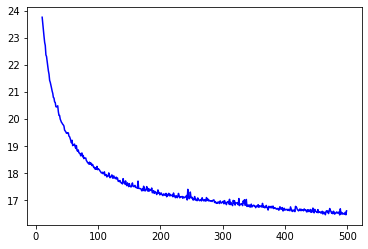

In [43]:
# Plot all but the first 10
loss = history.history['loss']
epochs = range(10, len(loss))
plot_loss = loss[10:]
print(plot_loss)
plt.plot(epochs, plot_loss, 'b', label='Training Loss')
plt.show()

# Predicting values

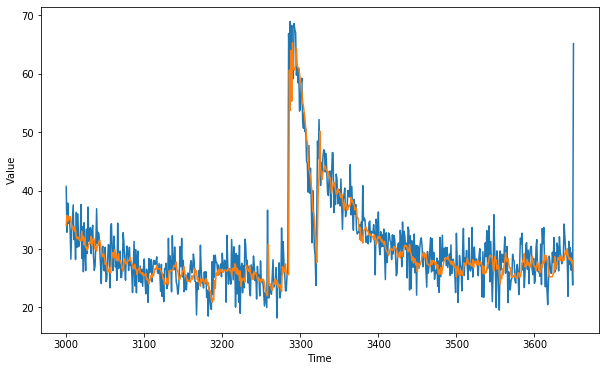

In [44]:
forecast = []
for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [45]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

2.8148797